## Read data

In [1]:
import json
from utils import export_df

with open("28-09_22-11_alldata.json", "r") as f:
    data = json.load(f)

## Data type
- s_* -> microphone input
- sonic (rmslog) -> low-frequency vibration
- temp
  - surface  
    ![](https://i.imgur.com/Gh3So2X.png)
  - external  
    ![](https://i.imgur.com/r3usdLI.png)
- vib -> vibration
  - acc
  - peak
  - root: removed due to its weird shape  
    ![](https://i.imgur.com/7nI0eCG.png)
  - f1/f2/f3
  - kurt
  - vibra_custom: it's always 1, dropping
  
- ![image.png](https://i.imgur.com/E3wAX58.png)


In [2]:
import pandas as pd
pd.DataFrame(data)

dfs = []
for result in data["results"]:
    serie = result["series"][0]
    for serie in result["series"]:
        df = pd.DataFrame(serie["values"], columns=serie["columns"])
        df.name = serie["name"]
        dfs.append(df)

In [3]:
df = dfs[0]
df_temp = dfs[2]
df_curr = dfs[3]
df = df.drop([
    'client', "GW", "device", "mileage", "vibra_custom",
    'vib_x_root', 'vib_y_root', 'vib_z_root',
], axis=1)
df_temp = df_temp.drop(['client', "GW", "device", 'weekday'], axis=1)
df_curr = df_curr.drop(['client', "GW", "device", 'weekday'], axis=1)

## Join dataframes

- df[0] -> Signature_Drift
- df[1] -> Signature
- df[2] -> Temperature
- df[3] -> Current_Loop

In [4]:
df = df.set_index('time')
# df = df.rename(columns={'temp': 'temperature_surface'})
df = df.drop("temp", axis=1)
df_temp = df_temp.set_index('time').rename(columns={"value": "temperature_external"})
df_curr = df_curr.set_index('time').rename(columns={"value": "current"})

# df = df.join(df_temp)
df = df.join(df_curr)

df = df.reset_index()
df["time"] = pd.to_datetime(df["time"], unit='ms')

# Label data

In [5]:
df.loc[(df["time"] >= "2021-10-09 00:00") & (df["time"] <= "2021-10-12 00:00"), "label"] = "working-engine-1"
df.loc[(df["time"] >= "2021-10-27 17:30") & (df["time"] <= "2021-10-29 00:00"), "label"] = "bearings-1"

df.loc[(df["time"] >= "2021-11-03 16:00") & (df["time"] <= "2021-11-05 11:00"), "label"] = "working-engine-2" # Every 2 minutes (TOCHECK)
df.loc[(df["time"] >= "2021-11-05 13:30") & (df["time"] <= "2021-11-05 23:59"), "label"] = "bearings-2" # Every 2 minutes (TOCHECK)
# 5th to 10th nothing happened
df.loc[(df["time"] >= "2021-11-10 16:30") & (df["time"] <= "2021-11-16 14:00"), "label"] = "magnet-partial"
df.loc[(df["time"] >= "2021-11-16 16:20") & (df["time"] <= "2021-12"), "label"] = "magnet-1" # TOUPDATE FINISH DATE

Group by hour

In [6]:
# Drops nan labels by default
# df = df.groupby([df.time.dt.date, df.time.dt.hour, 'label']).mean()
# df.index.names = ["date", "hour", 'label']

Pair plot

## Remove outliers


In [7]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

df = df.dropna()
df_base = df.copy()

In [8]:
for label in df.label.unique():
    dff = df[df.label == label]
    # dff = dff.reset_index()
    dff = dff.drop(["time", "label", "vib_z_f1", "vib_z_f2", "vib_z_f3"], axis=1)
    dff = dff.filter([
        's_00', 's_01', 's_02', 's_03', 's_04', 's_05', 's_06', 's_07', 's_08',
        's_09', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17',
        's_18', 's_19',
        'sonic_custom', 'sonic_rmslog', 'vib_x_acc',
        #'vib_x_f1', 'vib_x_f2', 'vib_x_f3',
        'vib_x_kurt', 'vib_x_peak', 'vib_x_vel',
        'vib_y_acc', 'vib_y_f1', 'vib_y_f2', 'vib_y_f3', 'vib_y_kurt',
        'vib_y_peak', 'vib_y_vel', 'vib_z_acc', 'vib_z_kurt', 'vib_z_peak',
        'vib_z_vel', 'temperature_external', 'current'
    ])
    dff = dff[~(np.abs(stats.zscore(dff)) < 3).all(axis=1)]
    df = df.drop(dff.index)

In [10]:
df

,time,s_00,s_01,s_02,s_03,s_04,s_05,s_06,s_07,s_08,...,vib_y_vel,vib_z_acc,vib_z_f1,vib_z_f2,vib_z_f3,vib_z_kurt,vib_z_peak,vib_z_vel,current,label
3050,2021-10-09 00:00:47.249,-0.068780,-4.477798,-6.905241,-4.547951,-2.283589,-0.124857,-1.274090,-0.499428,-1.128634,...,2.844896,1.684042,1.109990,2.106870,0.603318,0.362336,0.576215,2.100146,3.967956,working-engine-1
3051,2021-10-09 00:05:47.003,0.368391,-5.471160,-5.840925,-3.531701,-1.571756,-1.326505,-1.415999,0.166629,-0.261158,...,2.838546,1.700080,4.016145,6.259542,4.072398,0.352717,0.611753,2.122022,3.950103,working-engine-1
3052,2021-10-09 00:10:46.911,0.063973,-5.670291,-6.273518,-3.701076,-2.121080,-0.683337,-1.354200,-0.224765,-0.041428,...,2.835371,1.668003,7.346115,10.625954,4.796380,0.353037,0.573677,2.068546,3.950103,working-engine-1
3053,2021-10-09 00:15:47.253,-0.116846,-5.862554,-6.252918,-3.568322,-2.457542,-0.948844,-0.878119,-0.618448,0.189746,...,2.863947,1.684042,5.206862,7.816794,4.404223,0.358809,0.581292,2.100146,3.960632,working-engine-1
3056,2021-10-09 00:30:46.705,-0.380064,-5.342985,-6.486381,-3.854429,-2.130236,-1.038109,-0.688144,0.228428,-0.586175,...,2.848071,1.684042,4.278507,6.473282,3.469080,0.353679,0.596522,2.102577,3.961089,working-engine-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24387,2021-11-22 11:33:37.598,0.117213,-0.862416,0.121430,-0.251412,0.460662,0.298635,0.257918,-0.307911,-0.360434,...,1.904471,1.017857,1.000000,1.000000,1.000000,1.044533,1.012060,1.068273,3.955596,magnet-1
24388,2021-11-22 11:35:37.586,0.298033,-1.253810,-0.661358,-0.743516,0.405729,0.834227,0.328872,-0.614617,-0.470299,...,1.855294,0.942460,1.000000,1.000000,1.000000,1.035951,0.868844,0.839357,3.950561,magnet-1
24389,2021-11-22 11:37:37.578,0.265989,-0.500777,-0.182988,-0.475720,0.023491,0.944092,0.580646,0.033128,-1.392707,...,1.828471,0.980159,1.000000,1.000000,1.000000,1.038475,1.040704,1.098795,3.948730,magnet-1
24390,2021-11-22 11:39:42.491,0.588717,-0.388623,0.677621,-0.342967,0.291287,-0.046982,0.688222,-0.101914,-0.271169,...,2.011765,0.942460,1.000000,1.000000,1.000000,0.978903,0.887940,1.236145,3.959258,magnet-1


## Export

In [11]:
df = df.drop("time", axis=1)
export_df(df, "1-data-cleaning-output.json")

## Visualize

In [12]:
df.columns

Index(['s_00', 's_01', 's_02', 's_03', 's_04', 's_05', 's_06', 's_07', 's_08',
       's_09', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17',
       's_18', 's_19', 'sonic_custom', 'sonic_rmslog', 'vib_x_acc', 'vib_x_f1',
       'vib_x_f2', 'vib_x_f3', 'vib_x_kurt', 'vib_x_peak', 'vib_x_vel',
       'vib_y_acc', 'vib_y_f1', 'vib_y_f2', 'vib_y_f3', 'vib_y_kurt',
       'vib_y_peak', 'vib_y_vel', 'vib_z_acc', 'vib_z_f1', 'vib_z_f2',
       'vib_z_f3', 'vib_z_kurt', 'vib_z_peak', 'vib_z_vel', 'current',
       'label'],
      dtype='object')

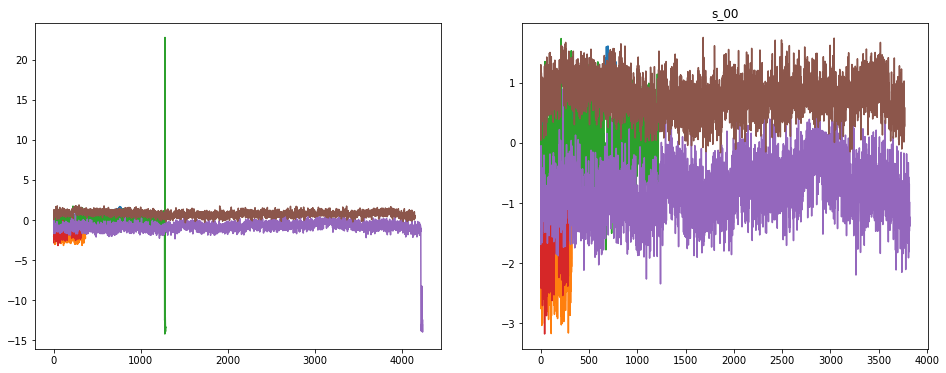

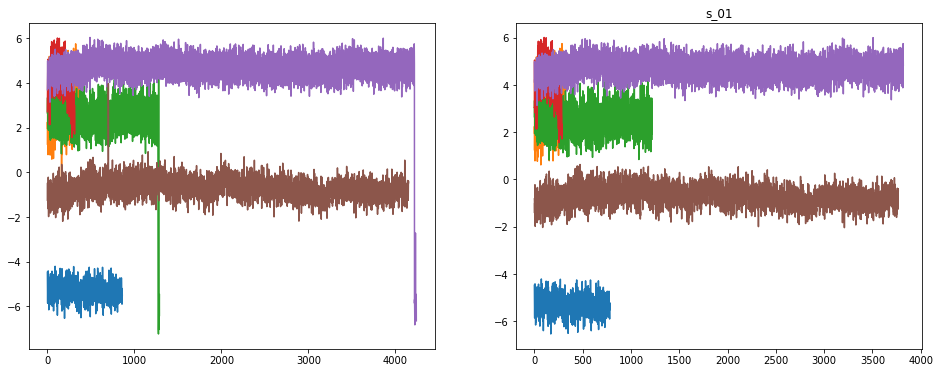

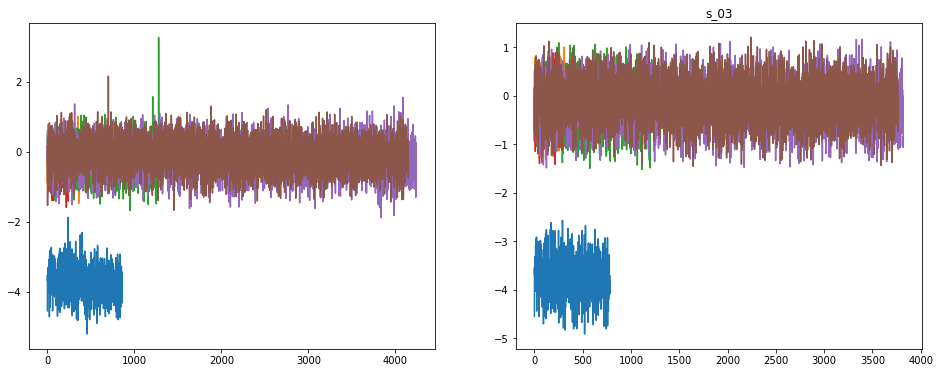

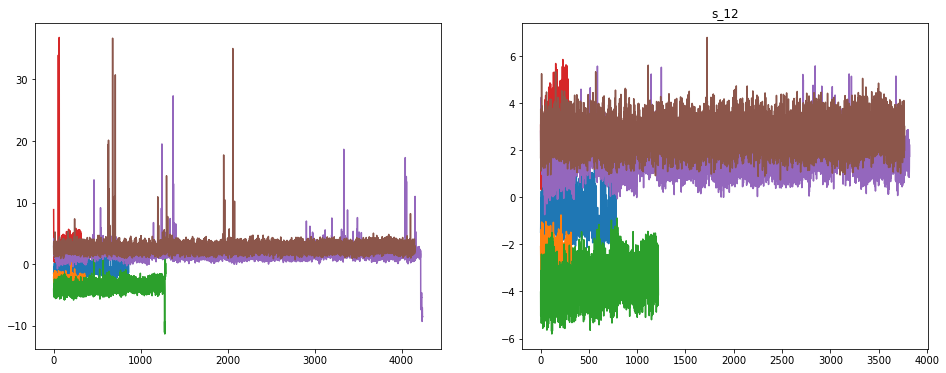

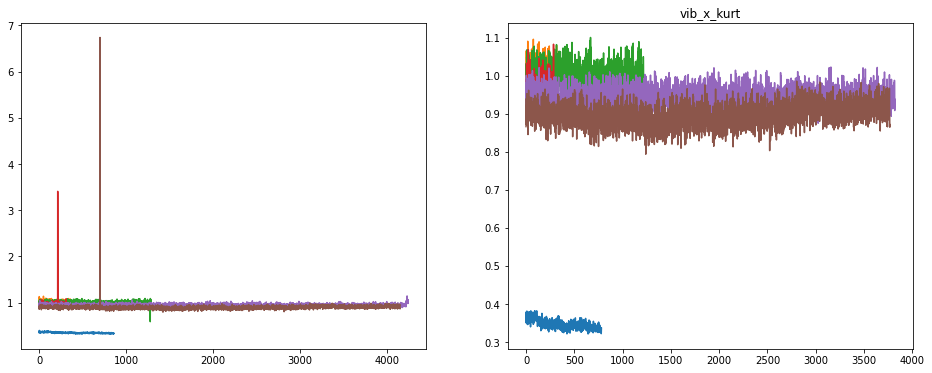

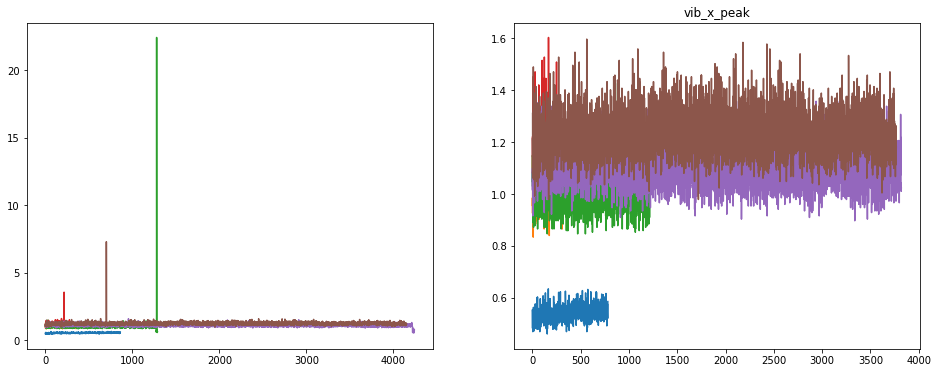

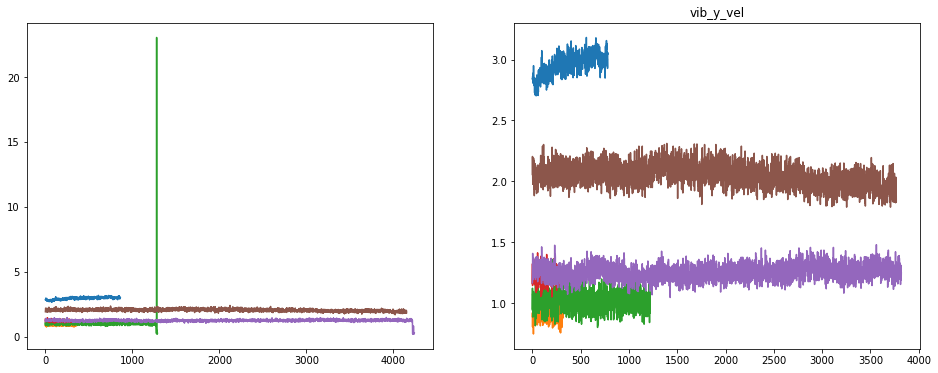

In [13]:
# for col in df.columns[1:-1]:
for col in ['s_00', 's_01', 's_03', 's_12', 'vib_x_kurt', 'vib_x_peak', 'vib_y_vel']:
    fig, (ax1, ax2) = plt.subplots(1,2)
    for label in df.label.unique():
        dff = df[df.label == label][col].reset_index()
        ax2.plot(dff[col], label=label)
        dff = df_base[df_base.label == label][col].reset_index()
        ax1.plot(dff[col], label=label)
    fig.set_size_inches(16, 6)
    plt.title(col)
    plt.show()